<center><h1>Covid19 Literature Clustering and Classification</h1></center>

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

This is a kaggle notebook solution to the kaggle problem: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

### Dataset Description

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 100,000 scholarly articles, about COVID-19, SARS-CoV-2, and related coronaviruses.

By using `clustering` for labelling in combination with `dimensionality reduction` for visualization, the collection of literature can be represented by a scatter plot. On this plot, publications of highly similar topic will share a label and will be plotted near each other. In order, to find meaning in the clusters, topic modelling will be performed to find the keywords of each cluster.

The text is parsed from the body of each document using <i><u>Natural Language Processing (NLP)</u></i>.
Each document instance di is turned into a feature vector Xi using <b>`Term Frequency–inverse Document Frequency (TF-IDF)`</b>. Applying <u><i>Dimensionality Reduction</i></u> to each feature vector Xi using <b>`t-Distributed Stochastic Neighbor Embedding (t-SNE)`</b> similar research articles are clustered in the two dimensional plane X embedding Y1. <i><u>Principal Component Analysis (PCA)</u></i> is used to project down the dimensions of X to a number of dimensions that keep .95 variance while removing noise and outliers in embedding Y2. <u><i>K-means clustering</i></u> is applied on Y2, where k is 20, to label each cluster on Y1. Applying <u><i>Topic Modeling</i></u> on X using <b>`Latent Dirichlet Allocation (LDA)`</b> keywords are discovered from each cluster. The clusters are investigated visually on the plot, zooming down to specific articles as needed, and via classification using <u><i>Stochastic Gradient Descent (SGD)</i></u>. 



![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


In [1]:
# Loading libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Loading meta data

root_path = '/kaggle/input/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={'pubmed_id': str,
                                            'Microsoft Academic Paper ID': str, 
                                            'doi': str 
                                           })
meta_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [3]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138794 entries, 0 to 138793
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          138794 non-null  object 
 1   sha               65379 non-null   object 
 2   source_x          138794 non-null  object 
 3   title             138753 non-null  object 
 4   doi               114271 non-null  object 
 5   pmcid             71391 non-null   object 
 6   pubmed_id         101517 non-null  object 
 7   license           138794 non-null  object 
 8   abstract          107032 non-null  object 
 9   publish_time      138780 non-null  object 
 10  authors           133451 non-null  object 
 11  journal           131249 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  26182 non-null   object 
 14  arxiv_id          1727 non-null    object 
 15  pdf_json_files    65379 non-null   object 
 16  pmc_json_files    50

In [4]:
# Get path to all JSON files:

all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

120464

In [5]:
# File Reader Class


class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

457ca409fb8641be73680f3697936d7a627f5442: ... An adenovirus (AVI group-specific latex agglutination test (LA) was assessed for its ability to detect AVs in faeces and to confirm the isolation of AVs in cell culture. It detected all of 62 strains ...


In [6]:
# adding break after every words when character length reach to certain amount.

def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

In [7]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 120464
Processing index: 12046 of 120464
Processing index: 24092 of 120464
Processing index: 36138 of 120464
Processing index: 48184 of 120464
Processing index: 60230 of 120464
Processing index: 72276 of 120464
Processing index: 84322 of 120464
Processing index: 96368 of 120464
Processing index: 108414 of 120464
Processing index: 120460 of 120464


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,457ca409fb8641be73680f3697936d7a627f5442,10.1016/0888-0786(93)90032-u,,An adenovirus (AVI group-specific latex agglut...,"Bryden, AS. Ashley, CR. Cotterill, H. <br>C...",Detection of adenoviruses in faeces and the<b...,Serodiagnosis and Immunotherapy in Infectious ...,Not provided.
1,7db22f7f81977109d493a0edf8ed75562648e839,10.1371/journal.pone.0103456,"Scorpine, a small cationic peptide from the ve...",The oldest known scorpions lived around 430 mi...,"Zhang, Chao. He, Xinlong. Gu, Yaping. Zhou...",Recombinant Scorpine Produced Using SUMO<br>F...,PLoS One,"Scorpine, a small cationic peptide from the<b..."
2,4a487430085a45904f4463e6e462a63f98adefad,10.1016/j.jemermed.2004.11.022,e Abstract-To differentiate severe acute respi...,Severe acute respiratory syndrome (SARS) is a ...,"Chang, Shang-Miao. Liu, Ching-Lung. Kuo,<br...",Comparative study of patients with and withou...,The Journal of Emergency Medicine,e Abstract-To differentiate severe acute<br>r...
3,66b16f35496816d1091009e6df08945485e57ffc,10.1101/2020.05.13.093971,The recently emerged SARS-CoV-2 (Coronaviridae...,"region. Phylogenetic analysis, natural selecti...","Nour, Islam. Alanazi, Ibrahim O.. Hanif, At...",Insights into molecular evolution<br>recombin...,bioRxiv,The recently emerged SARS-CoV-2<br>(Coronavir...
4,d95fb677837e1d2572cfdc7dd95a630d5f64930d,10.1016/j.outlook.2012.07.013,The increasing interconnectedness of the world...,The increasing interconnectedness in the world...,"Hunter, Anita. Wilson, Lynda. Stanhope,<br>...",Global health diplomacy: An integrative<br>re...,Nursing Outlook,The increasing interconnectedness of the<br>w...


In [8]:
# Adding word count columns for both abstract and body_text

df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,457ca409fb8641be73680f3697936d7a627f5442,10.1016/0888-0786(93)90032-u,,An adenovirus (AVI group-specific latex agglut...,"Bryden, AS. Ashley, CR. Cotterill, H. <br>C...",Detection of adenoviruses in faeces and the<b...,Serodiagnosis and Immunotherapy in Infectious ...,Not provided.,0,1616,643
1,7db22f7f81977109d493a0edf8ed75562648e839,10.1371/journal.pone.0103456,"Scorpine, a small cationic peptide from the ve...",The oldest known scorpions lived around 430 mi...,"Zhang, Chao. He, Xinlong. Gu, Yaping. Zhou...",Recombinant Scorpine Produced Using SUMO<br>F...,PLoS One,"Scorpine, a small cationic peptide from the<b...",253,3543,1332
2,4a487430085a45904f4463e6e462a63f98adefad,10.1016/j.jemermed.2004.11.022,e Abstract-To differentiate severe acute respi...,Severe acute respiratory syndrome (SARS) is a ...,"Chang, Shang-Miao. Liu, Ching-Lung. Kuo,<br...",Comparative study of patients with and withou...,The Journal of Emergency Medicine,e Abstract-To differentiate severe acute<br>r...,183,3060,1086
3,66b16f35496816d1091009e6df08945485e57ffc,10.1101/2020.05.13.093971,The recently emerged SARS-CoV-2 (Coronaviridae...,"region. Phylogenetic analysis, natural selecti...","Nour, Islam. Alanazi, Ibrahim O.. Hanif, At...",Insights into molecular evolution<br>recombin...,bioRxiv,The recently emerged SARS-CoV-2<br>(Coronavir...,174,461,267
4,d95fb677837e1d2572cfdc7dd95a630d5f64930d,10.1016/j.outlook.2012.07.013,The increasing interconnectedness of the world...,The increasing interconnectedness in the world...,"Hunter, Anita. Wilson, Lynda. Stanhope,<br>...",Global health diplomacy: An integrative<br>re...,Nursing Outlook,The increasing interconnectedness of the<br>w...,226,4228,1437


In [9]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61655 entries, 0 to 61654
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             61655 non-null  object
 1   doi                  59833 non-null  object
 2   abstract             61655 non-null  object
 3   body_text            61655 non-null  object
 4   authors              60366 non-null  object
 5   title                61654 non-null  object
 6   journal              56315 non-null  object
 7   abstract_summary     61655 non-null  object
 8   abstract_word_count  61655 non-null  int64 
 9   body_word_count      61655 non-null  int64 
 10  body_unique_words    61655 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 5.2+ MB


In [10]:
df_covid['abstract'].describe(include='all')

count     61655
unique    42612
top            
freq      18784
Name: abstract, dtype: object

In [11]:
# Handling duplicates

df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     61501
unique    42612
top            
freq      18686
Name: abstract, dtype: object

In [12]:
df_covid['body_text'].describe(include='all')

count                                                 61501
unique                                                61498
top       The recent COVID-19 Coronavirus outbreak and t...
freq                                                      2
Name: body_text, dtype: object

## Data Pre-processing

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


In [13]:
# In Kaggle we cannot handle the whole dataframe. So we limit the dataframe to 10,000 instances

df = df_covid.sample(10000, random_state=42)
del df_covid

In [14]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8869 entries, 29945 to 51559
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             8869 non-null   object
 1   doi                  8869 non-null   object
 2   abstract             8869 non-null   object
 3   body_text            8869 non-null   object
 4   authors              8869 non-null   object
 5   title                8869 non-null   object
 6   journal              8869 non-null   object
 7   abstract_summary     8869 non-null   object
 8   abstract_word_count  8869 non-null   int64 
 9   body_word_count      8869 non-null   int64 
 10  body_unique_words    8869 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 831.5+ KB


### Handling multiple languages

In [15]:
!pip install langdetect

     |████████████████████████████████| 981 kB 4.5 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=ad692989d4d33c3eef0e24c95309b1bab84be7bf630d6b6f0ed18ef92dd66fc0
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 8869/8869 [01:48<00:00, 81.80it/s]


In [17]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 8869

{'de': 126, 'en': 8540, 'es': 95, 'fr': 71, 'it': 7, 'nl': 25, 'pt': 5}


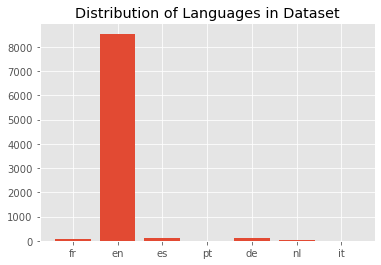

In [18]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [19]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8540 entries, 29945 to 51559
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             8540 non-null   object
 1   doi                  8540 non-null   object
 2   abstract             8540 non-null   object
 3   body_text            8540 non-null   object
 4   authors              8540 non-null   object
 5   title                8540 non-null   object
 6   journal              8540 non-null   object
 7   abstract_summary     8540 non-null   object
 8   abstract_word_count  8540 non-null   int64 
 9   body_word_count      8540 non-null   int64 
 10  body_unique_words    8540 non-null   int64 
 11  language             8540 non-null   object
dtypes: int64(3), object(9)
memory usage: 867.3+ KB


In [20]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [21]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

In [22]:
# finding and removing stopwords (common words that will act as noise in the clustering step).

import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['anywhere',
 'to',
 'between',
 '’ve',
 'herself',
 'get',
 'might',
 "'ve",
 'fifty',
 'within']

In [23]:
# Reference: https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [24]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [25]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 8540/8540 [52:32<00:00,  2.71it/s]   


### Word count in the papers

count      8540.000000
mean       3903.383255
std        4290.373956
min          13.000000
25%        1720.750000
50%        3180.000000
75%        4912.500000
max      140853.000000
Name: body_word_count, dtype: float64

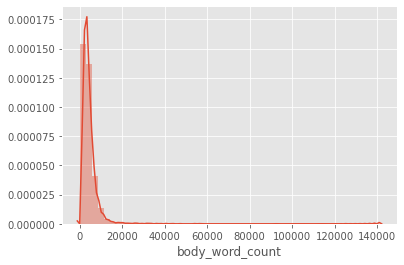

In [26]:
import seaborn as sns
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     8540.000000
mean      1248.926932
std        894.493538
min         13.000000
25%        734.750000
50%       1123.000000
75%       1543.000000
max      20966.000000
Name: body_unique_words, dtype: float64

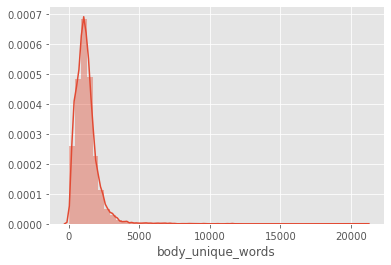

In [27]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

## Vectorization
Converting the into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)



In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

We will be clustering based on the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [29]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(8540, 4096)

## PCA & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(8540, 2218)

To separate the literature, k-means will be run on the vectorized text

In [31]:
from sklearn.cluster import KMeans

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [32]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

Found distortion for 2 clusters
Found distortion for 3 clusters
Found distortion for 4 clusters
Found distortion for 5 clusters
Found distortion for 6 clusters
Found distortion for 7 clusters
Found distortion for 8 clusters
Found distortion for 9 clusters
Found distortion for 10 clusters
Found distortion for 11 clusters
Found distortion for 12 clusters
Found distortion for 13 clusters
Found distortion for 14 clusters
Found distortion for 15 clusters
Found distortion for 16 clusters
Found distortion for 17 clusters
Found distortion for 18 clusters
Found distortion for 19 clusters
Found distortion for 20 clusters
Found distortion for 21 clusters
Found distortion for 22 clusters
Found distortion for 23 clusters
Found distortion for 24 clusters
Found distortion for 25 clusters
Found distortion for 26 clusters
Found distortion for 27 clusters
Found distortion for 28 clusters
Found distortion for 29 clusters


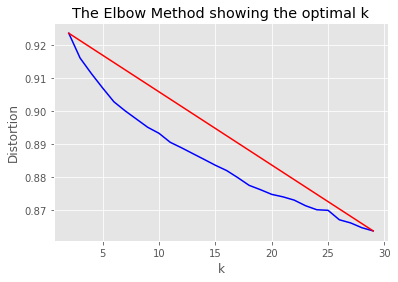

In [33]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred


## Dimensionality Reduction with t-SNE

Using t-SNE we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted.

`t-Distributed Stochastic Neighbor Embedding (t-SNE)` reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 8540 samples in 8.117s...
[t-SNE] Computed neighbors for 8540 samples in 791.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8540
[t-SNE] Computed conditional probabilities for sample 2000 / 8540
[t-SNE] Computed conditional probabilities for sample 3000 / 8540
[t-SNE] Computed conditional probabilities for sample 4000 / 8540
[t-SNE] Computed conditional probabilities for sample 5000 / 8540
[t-SNE] Computed conditional probabilities for sample 6000 / 8540
[t-SNE] Computed conditional probabilities for sample 7000 / 8540
[t-SNE] Computed conditional probabilities for sample 8000 / 8540
[t-SNE] Computed conditional probabilities for sample 8540 / 8540
[t-SNE] Mean sigma: 0.359573
[t-SNE] KL divergence after 100 iterations with early exaggeration: 80.265076
[t-SNE] KL divergence after 1000 iterations: 1.896784


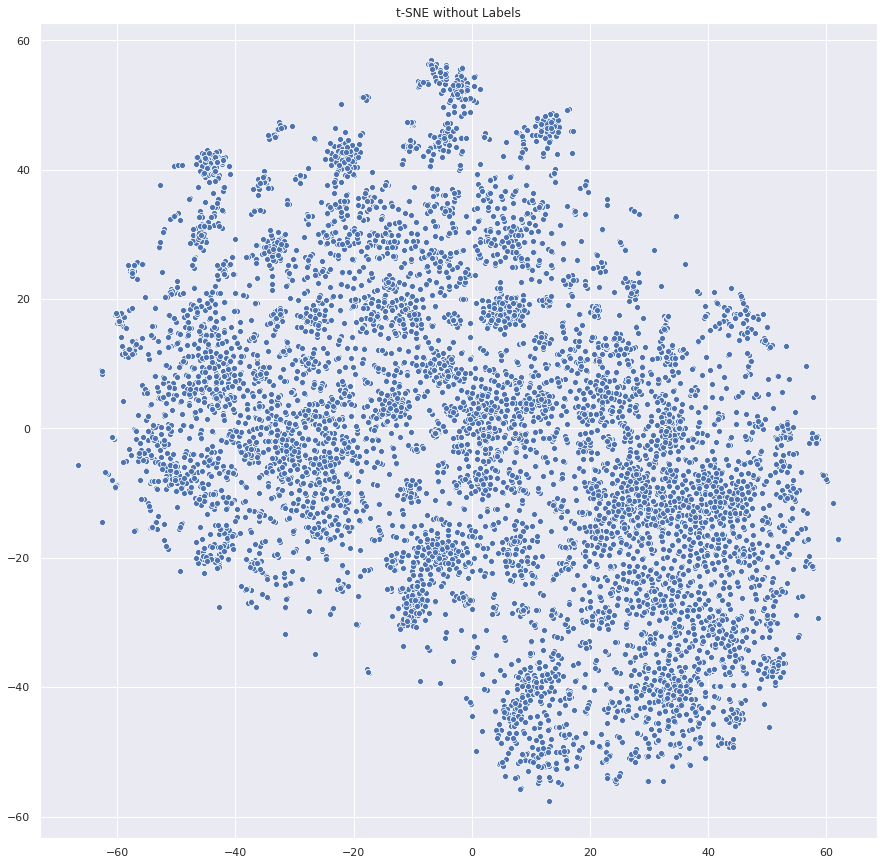

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE without Labels')
plt.savefig("t-SNE_covid19.png")
plt.show()

 There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

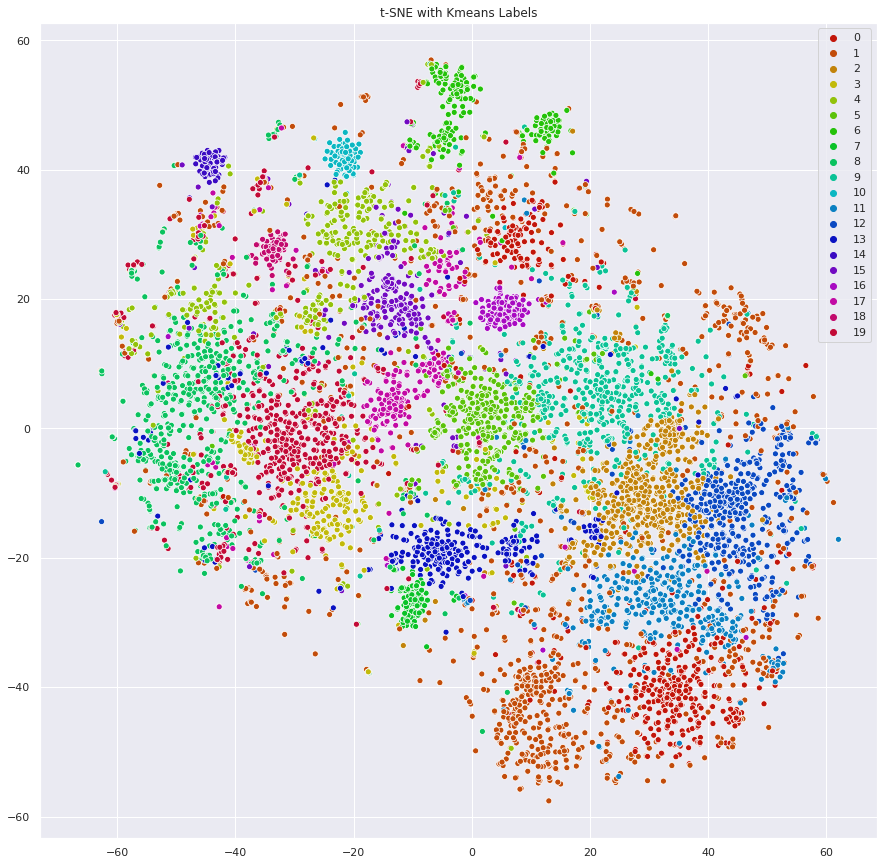

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("t-SNE_K-means_covid19.png")
plt.show()



The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independently. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent.

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.





## Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use `LDA (Latent Dirichlet Allocation)`. In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


In [38]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [40]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [41]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [42]:
len(vectorized_data)

20

In [43]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)



For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors


In [44]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))



### Extracting the keywords from each cluster


In [45]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [46]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [47]:
all_keywords[0][:10]

['human',
 'research',
 'disease',
 'disaster',
 'animal',
 'study',
 'outbreak',
 'information',
 'development',
 'science']

In [48]:
len(all_keywords)

20

In [49]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [50]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

## Classification

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)


In [51]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [52]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 6832
X_test size: 1708 



In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  88.100 %
     Precision:  90.069 %
        Recall:  89.797 %
      F1 score:  89.879 %


To test for overfitting, let's see how the model generalizes over the test set


In [54]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  82.084 %
     Precision:  87.492 %
        Recall:  81.240 %
      F1 score:  83.763 %




Now let's see how the model can generalize across the whole dataset.


In [55]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 90.070 %


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
